# Transformer Attention Mechanism Visualization

This notebook demonstrates the complete attention mechanism with visual heatmaps at each step.

**Steps we'll visualize:**
1. Q, K, V matrices
2. Raw attention scores (Q @ K^T)
3. Scaled scores (÷√d_k)
4. Attention weights (after softmax)
5. Final output (weighted sum of values)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Set style for better plots
plt.style.use('default')
sns.set_palette("viridis")

# Set seed for reproducible results
torch.manual_seed(42)
np.random.seed(42)

In [5]:
# Setup parameters
sentence = ["hello", "world", "this", "is", "a", "test"]
batch_size = 1
seq_len = 6
d_model = 4

print(f"Sentence: {' '.join(sentence)}")
print(f"Sequence length: {seq_len}")
print(f"Model dimension: {d_model}")

# Create input embeddings
x = torch.randn(batch_size, seq_len, d_model)
print(f"\nInput shape: {x.shape}")

Sentence: hello world this is a test
Sequence length: 6
Model dimension: 4

Input shape: torch.Size([1, 6, 4])


In [6]:
# Create linear transformation layers
query_layer = nn.Linear(d_model, d_model)
key_layer = nn.Linear(d_model, d_model)
value_layer = nn.Linear(d_model, d_model)

# Generate Q, K, V matrices
Q = query_layer(x)  # [1, 6, 4]
K = key_layer(x)    # [1, 6, 4]
V = value_layer(x)  # [1, 6, 4]

# Remove batch dimension for visualization
Q_2d = Q.squeeze(0).detach().numpy()  # [6, 4]
K_2d = K.squeeze(0).detach().numpy()  # [6, 4]
V_2d = V.squeeze(0).detach().numpy()  # [6, 4]

print(f"Q matrix shape: {Q_2d.shape}")
print(f"K matrix shape: {K_2d.shape}")
print(f"V matrix shape: {V_2d.shape}")

Q matrix shape: (6, 4)
K matrix shape: (6, 4)
V matrix shape: (6, 4)


## Step 1: Visualize Q, K, V Matrices

These matrices represent:
- **Q (Query)**: What each token is looking for
- **K (Key)**: What each token offers
- **V (Value)**: The actual information each token contains

In [7]:
# Create a function for consistent heatmap styling
def plot_matrix(matrix, title, tokens=None, features=None, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    
    # Create heatmap
    ax = sns.heatmap(matrix, 
                     annot=True, 
                     fmt='.3f', 
                     cmap='RdBu_r', 
                     center=0,
                     square=True,
                     linewidths=0.5,
                     cbar_kws={"shrink": .8})
    
    # Set labels
    if tokens is not None:
        ax.set_yticklabels(tokens, rotation=0)
    if features is not None:
        ax.set_xticklabels(features, rotation=0)
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Features/Dimensions')
    plt.ylabel('Tokens')
    plt.tight_layout()
    plt.show()

# Feature labels
feature_labels = [f'dim{i}' for i in range(d_model)]

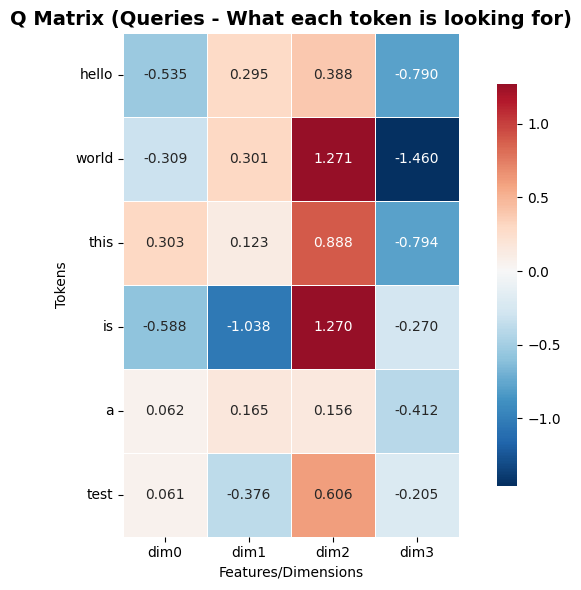

Q Matrix Values:
hello: [ -0.535,   0.295,   0.388,  -0.790]
world: [ -0.309,   0.301,   1.271,  -1.460]
 this: [  0.303,   0.123,   0.888,  -0.794]
   is: [ -0.588,  -1.038,   1.270,  -0.270]
    a: [  0.062,   0.165,   0.156,  -0.412]
 test: [  0.061,  -0.376,   0.606,  -0.205]


In [8]:
# Plot Q matrix
plot_matrix(Q_2d, 'Q Matrix (Queries - What each token is looking for)', 
           tokens=sentence, features=feature_labels)

print("Q Matrix Values:")
for i, token in enumerate(sentence):
    print(f"{token:>5}: [{Q_2d[i,0]:7.3f}, {Q_2d[i,1]:7.3f}, {Q_2d[i,2]:7.3f}, {Q_2d[i,3]:7.3f}]")

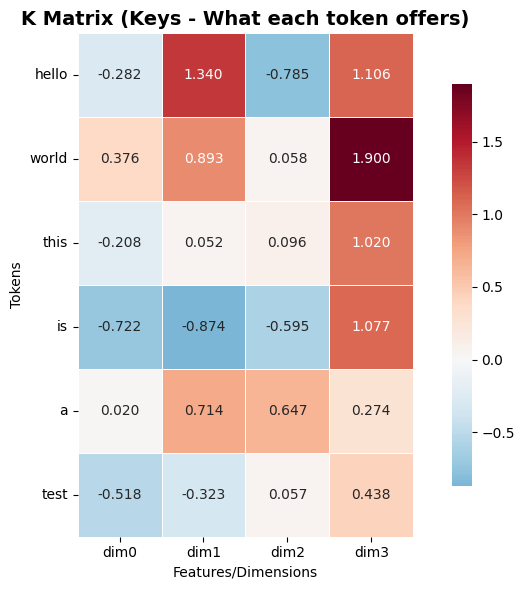

K Matrix Values:
hello: [ -0.282,   1.340,  -0.785,   1.106]
world: [  0.376,   0.893,   0.058,   1.900]
 this: [ -0.208,   0.052,   0.096,   1.020]
   is: [ -0.722,  -0.874,  -0.595,   1.077]
    a: [  0.020,   0.714,   0.647,   0.274]
 test: [ -0.518,  -0.323,   0.057,   0.438]


In [9]:
# Plot K matrix
plot_matrix(K_2d, 'K Matrix (Keys - What each token offers)', 
           tokens=sentence, features=feature_labels)

print("K Matrix Values:")
for i, token in enumerate(sentence):
    print(f"{token:>5}: [{K_2d[i,0]:7.3f}, {K_2d[i,1]:7.3f}, {K_2d[i,2]:7.3f}, {K_2d[i,3]:7.3f}]")

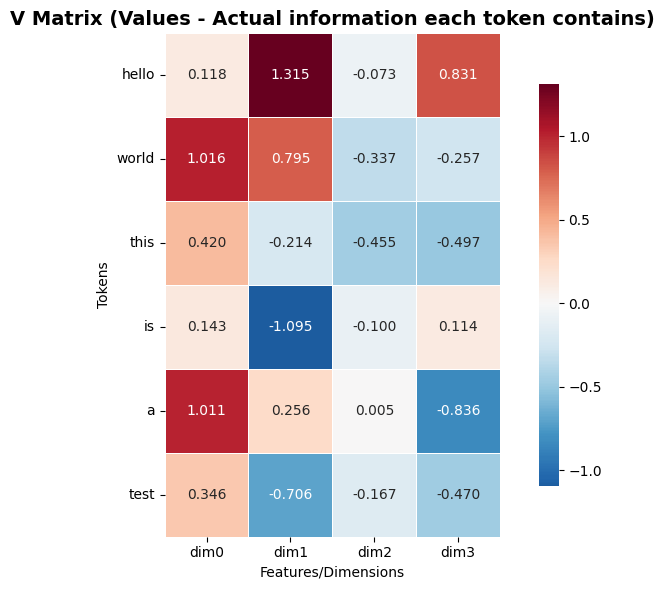

V Matrix Values:
hello: [  0.118,   1.315,  -0.073,   0.831]
world: [  1.016,   0.795,  -0.337,  -0.257]
 this: [  0.420,  -0.214,  -0.455,  -0.497]
   is: [  0.143,  -1.095,  -0.100,   0.114]
    a: [  1.011,   0.256,   0.005,  -0.836]
 test: [  0.346,  -0.706,  -0.167,  -0.470]


In [11]:
# Plot V matrix
plot_matrix(V_2d, 'V Matrix (Values - Actual information each token contains)', 
           tokens=sentence, features=feature_labels)

print("V Matrix Values:")
for i, token in enumerate(sentence):
    print(f"{token:>5}: [{V_2d[i,0]:7.3f}, {V_2d[i,1]:7.3f}, {V_2d[i,2]:7.3f}, {V_2d[i,3]:7.3f}]")

## Step 2: Calculate Raw Attention Scores (Q @ K^T)

The raw attention scores show how compatible each query is with each key.

In [12]:
# Calculate raw attention scores
K_transposed = K.transpose(-2, -1)  # [1, 4, 6]
raw_scores = torch.matmul(Q, K_transposed)  # [1, 6, 6]
raw_scores_2d = raw_scores.squeeze(0).detach().numpy()  # [6, 6]

print(f"Raw scores shape: {raw_scores_2d.shape}")
print(f"This is a {seq_len}x{seq_len} matrix showing attention from each token to every token")

Raw scores shape: (6, 6)
This is a 6x6 matrix showing attention from each token to every token


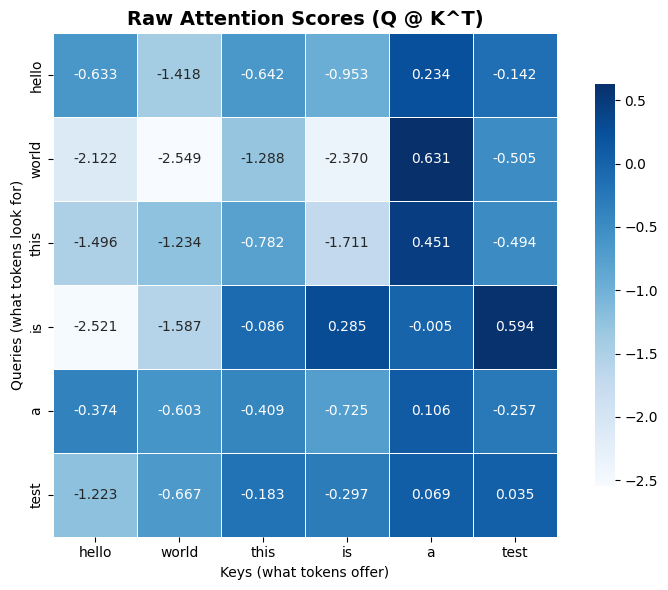


Interpretation:
raw_scores[0,1] = -1.418 = how much 'hello' query matches 'world' key
raw_scores[2,5] = -0.494 = how much 'this' query matches 'test' key


In [13]:
# Function for plotting attention matrices
def plot_attention_matrix(matrix, title, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    
    ax = sns.heatmap(matrix, 
                     annot=True, 
                     fmt='.3f', 
                     cmap='Blues', 
                     square=True,
                     linewidths=0.5,
                     xticklabels=sentence,
                     yticklabels=sentence,
                     cbar_kws={"shrink": .8})
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Keys (what tokens offer)')
    plt.ylabel('Queries (what tokens look for)')
    plt.tight_layout()
    plt.show()

# Plot raw attention scores
plot_attention_matrix(raw_scores_2d, 'Raw Attention Scores (Q @ K^T)')

print("\nInterpretation:")
print(f"raw_scores[0,1] = {raw_scores_2d[0,1]:.3f} = how much 'hello' query matches 'world' key")
print(f"raw_scores[2,5] = {raw_scores_2d[2,5]:.3f} = how much 'this' query matches 'test' key")

## Step 3: Scale Scores by √d_k

Scaling prevents the softmax function from having very small gradients when the dot products are large.

In [14]:
# Scale by sqrt(d_k)
d_k = d_model  # In this case, d_k = d_model = 4
scale_factor = math.sqrt(d_k)
print(f"d_k = {d_k}")
print(f"Scale factor = √d_k = √{d_k} = {scale_factor:.3f}")

scaled_scores = raw_scores / scale_factor
scaled_scores_2d = scaled_scores.squeeze(0).detach().numpy()

print(f"\nScaling effect:")
print(f"Before scaling - hello->world: {raw_scores_2d[0,1]:.3f}")
print(f"After scaling  - hello->world: {scaled_scores_2d[0,1]:.3f}")

d_k = 4
Scale factor = √d_k = √4 = 2.000

Scaling effect:
Before scaling - hello->world: -1.418
After scaling  - hello->world: -0.709


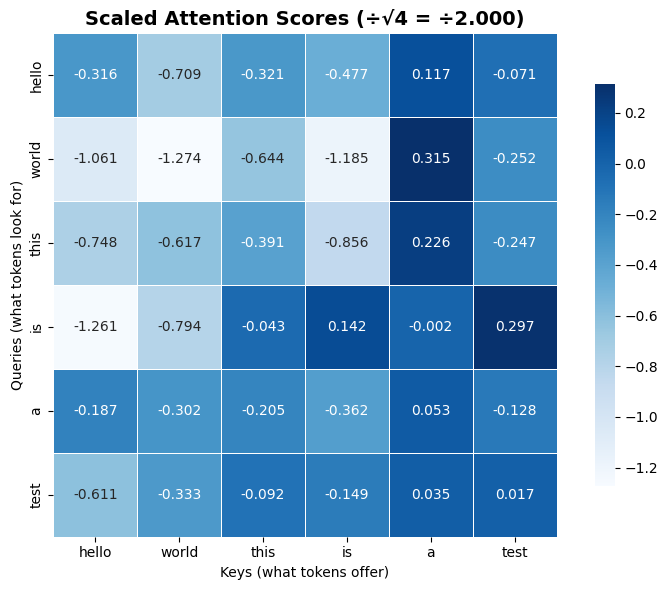

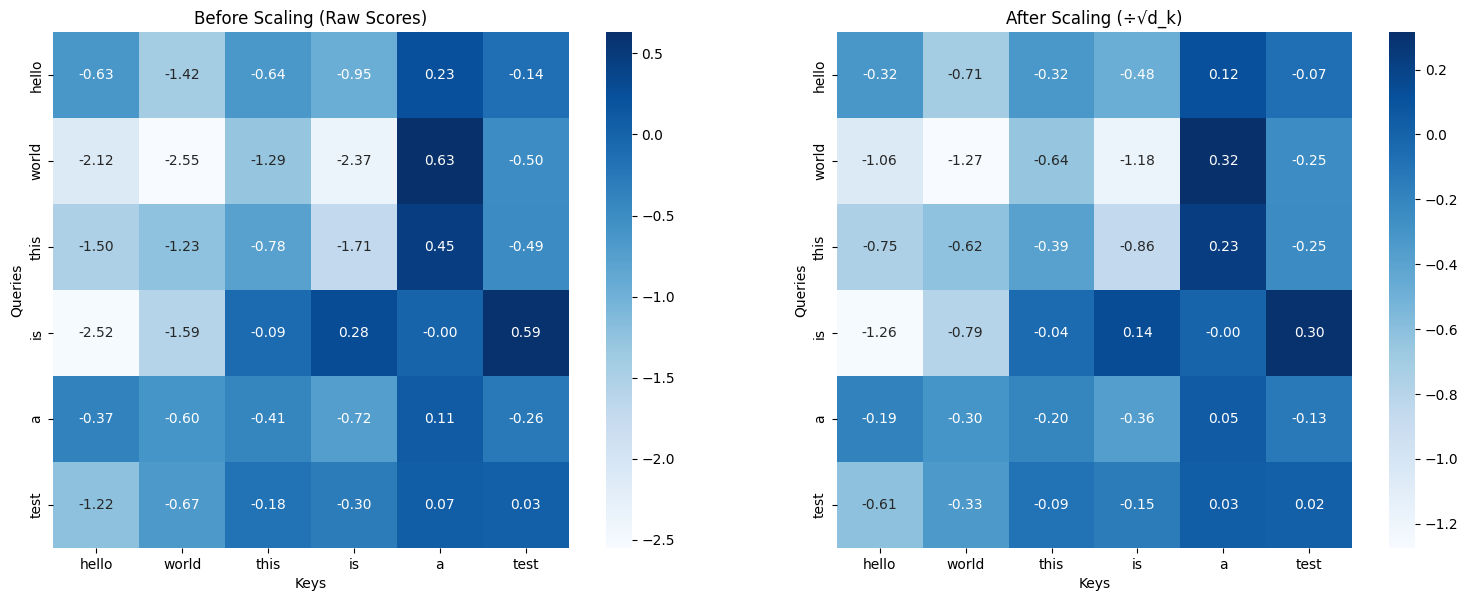

In [15]:
# Plot scaled scores
plot_attention_matrix(scaled_scores_2d, f'Scaled Attention Scores (÷√{d_k} = ÷{scale_factor:.3f})')

# Show comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Raw scores
sns.heatmap(raw_scores_2d, annot=True, fmt='.2f', cmap='Blues', 
           xticklabels=sentence, yticklabels=sentence, ax=ax1, square=True)
ax1.set_title('Before Scaling (Raw Scores)')
ax1.set_xlabel('Keys')
ax1.set_ylabel('Queries')

# Scaled scores
sns.heatmap(scaled_scores_2d, annot=True, fmt='.2f', cmap='Blues', 
           xticklabels=sentence, yticklabels=sentence, ax=ax2, square=True)
ax2.set_title('After Scaling (÷√d_k)')
ax2.set_xlabel('Keys')
ax2.set_ylabel('Queries')

plt.tight_layout()
plt.show()

## Step 4: Apply Softmax to Get Attention Weights

Softmax converts the scaled scores into a probability distribution (each row sums to 1).

In [16]:
# Apply softmax
attention_weights = F.softmax(scaled_scores, dim=-1)
attention_weights_2d = attention_weights.squeeze(0).detach().numpy()

print("Attention weights properties:")
print(f"Shape: {attention_weights_2d.shape}")
print(f"All values between 0 and 1: {np.all((attention_weights_2d >= 0) & (attention_weights_2d <= 1))}")
print(f"Each row sums to 1: {np.allclose(attention_weights_2d.sum(axis=1), 1.0)}")

# Show row sums
print("\nRow sums (should all be 1.0):")
for i, token in enumerate(sentence):
    row_sum = attention_weights_2d[i].sum()
    print(f"{token:>5}: {row_sum:.6f}")

Attention weights properties:
Shape: (6, 6)
All values between 0 and 1: True
Each row sums to 1: True

Row sums (should all be 1.0):
hello: 1.000000
world: 1.000000
 this: 1.000000
   is: 1.000000
    a: 1.000000
 test: 1.000000


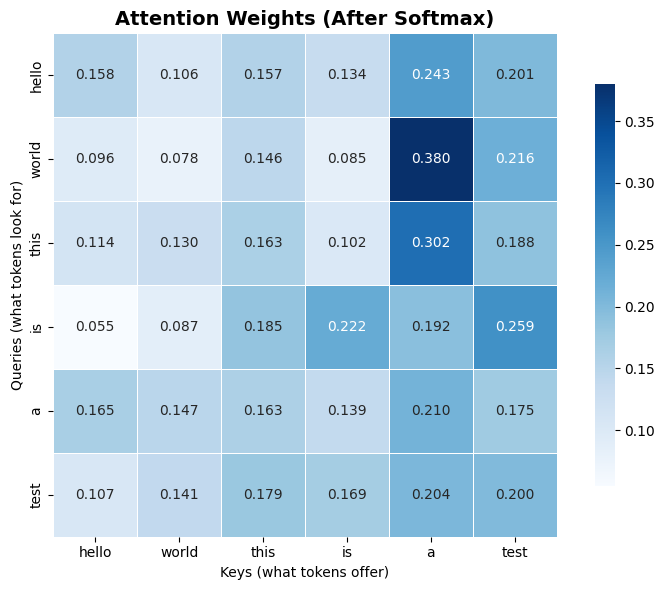

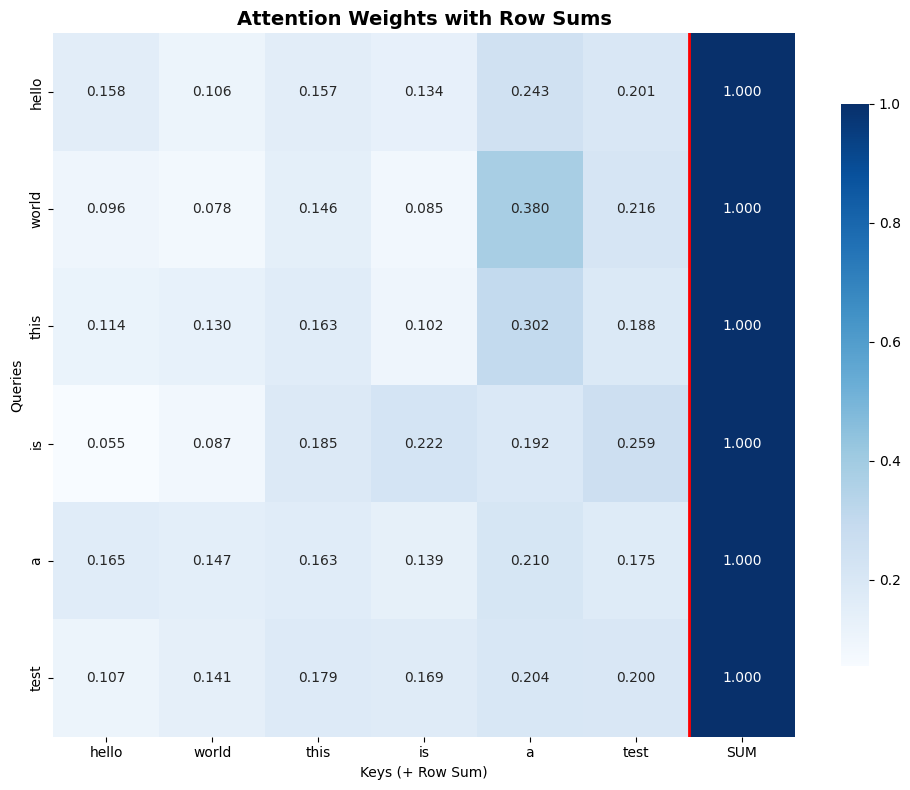

In [17]:
# Plot attention weights
plot_attention_matrix(attention_weights_2d, 'Attention Weights (After Softmax)')

# Create a more detailed heatmap with row sums
fig, ax = plt.subplots(figsize=(10, 8))

# Add row sums as an extra column
weights_with_sums = np.column_stack([attention_weights_2d, attention_weights_2d.sum(axis=1)])
labels_with_sum = sentence + ['SUM']

sns.heatmap(weights_with_sums, 
           annot=True, 
           fmt='.3f', 
           cmap='Blues', 
           square=False,
           xticklabels=labels_with_sum,
           yticklabels=sentence,
           ax=ax,
           cbar_kws={"shrink": .8})

ax.set_title('Attention Weights with Row Sums', fontsize=14, fontweight='bold')
ax.set_xlabel('Keys (+ Row Sum)')
ax.set_ylabel('Queries')

# Highlight the sum column
ax.axvline(x=6, color='red', linewidth=2)

plt.tight_layout()
plt.show()

## Step 5: Calculate Final Output (Weighted Sum of Values)

The final step multiplies attention weights with values to get the output representation for each token.

In [18]:
# Calculate final output
output = torch.matmul(attention_weights, V)  # [1, 6, 6] @ [1, 6, 4] = [1, 6, 4]
output_2d = output.squeeze(0).detach().numpy()  # [6, 4]

print(f"Output shape: {output_2d.shape}")
print(f"Each token now has a new representation based on attention-weighted values")

Output shape: (6, 4)
Each token now has a new representation based on attention-weighted values


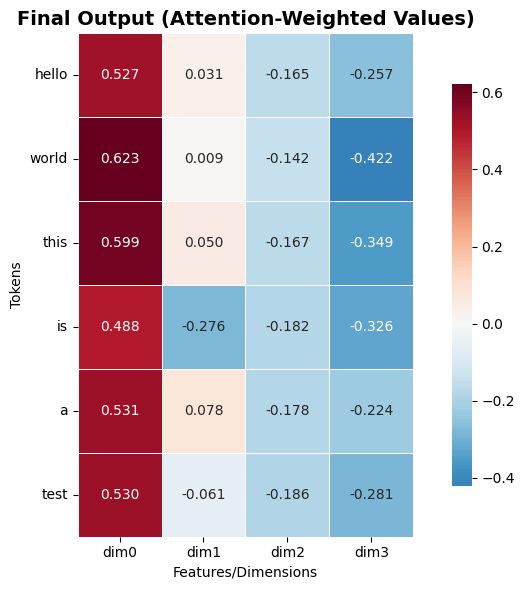

Final Output Values:
hello: [  0.527,   0.031,  -0.165,  -0.257]
world: [  0.623,   0.009,  -0.142,  -0.422]
 this: [  0.599,   0.050,  -0.167,  -0.349]
   is: [  0.488,  -0.276,  -0.182,  -0.326]
    a: [  0.531,   0.078,  -0.178,  -0.224]
 test: [  0.530,  -0.061,  -0.186,  -0.281]


In [19]:
# Plot final output
plot_matrix(output_2d, 'Final Output (Attention-Weighted Values)', 
           tokens=sentence, features=feature_labels)

print("Final Output Values:")
for i, token in enumerate(sentence):
    print(f"{token:>5}: [{output_2d[i,0]:7.3f}, {output_2d[i,1]:7.3f}, {output_2d[i,2]:7.3f}, {output_2d[i,3]:7.3f}]")

## Step 6: Detailed Example - How 'hello' Output is Calculated

Let's manually verify how the output for 'hello' is computed.

In [20]:
# Manual calculation for 'hello' (token 0)
token_idx = 0
token_name = sentence[token_idx]

print(f"Calculating output for '{token_name}' (index {token_idx}):")
print("\n1. Attention weights for 'hello':")
for j, target_token in enumerate(sentence):
    weight = attention_weights_2d[token_idx, j]
    print(f"   Attention to '{target_token}': {weight:.4f}")

print("\n2. Value vectors being weighted:")
for j, target_token in enumerate(sentence):
    values = V_2d[j, :]
    print(f"   V[{target_token}] = [{values[0]:7.3f}, {values[1]:7.3f}, {values[2]:7.3f}, {values[3]:7.3f}]")

print("\n3. Weighted sum calculation:")
manual_output = np.zeros(d_model)
for j in range(seq_len):
    weight = attention_weights_2d[token_idx, j]
    value_vec = V_2d[j, :]
    weighted_value = weight * value_vec
    manual_output += weighted_value
    print(f"   + {weight:.4f} * [{value_vec[0]:7.3f}, {value_vec[1]:7.3f}, {value_vec[2]:7.3f}, {value_vec[3]:7.3f}] = [{weighted_value[0]:7.3f}, {weighted_value[1]:7.3f}, {weighted_value[2]:7.3f}, {weighted_value[3]:7.3f}]")

print(f"\n4. Final result:")
print(f"   Manual calculation: [{manual_output[0]:7.3f}, {manual_output[1]:7.3f}, {manual_output[2]:7.3f}, {manual_output[3]:7.3f}]")
print(f"   Matrix calculation: [{output_2d[token_idx,0]:7.3f}, {output_2d[token_idx,1]:7.3f}, {output_2d[token_idx,2]:7.3f}, {output_2d[token_idx,3]:7.3f}]")
print(f"   ✓ Match: {np.allclose(manual_output, output_2d[token_idx, :], atol=1e-6)}")

Calculating output for 'hello' (index 0):

1. Attention weights for 'hello':
   Attention to 'hello': 0.1576
   Attention to 'world': 0.1065
   Attention to 'this': 0.1569
   Attention to 'is': 0.1343
   Attention to 'a': 0.2432
   Attention to 'test': 0.2015

2. Value vectors being weighted:
   V[hello] = [  0.118,   1.315,  -0.073,   0.831]
   V[world] = [  1.016,   0.795,  -0.337,  -0.257]
   V[this] = [  0.420,  -0.214,  -0.455,  -0.497]
   V[is] = [  0.143,  -1.095,  -0.100,   0.114]
   V[a] = [  1.011,   0.256,   0.005,  -0.836]
   V[test] = [  0.346,  -0.706,  -0.167,  -0.470]

3. Weighted sum calculation:
   + 0.1576 * [  0.118,   1.315,  -0.073,   0.831] = [  0.019,   0.207,  -0.012,   0.131]
   + 0.1065 * [  1.016,   0.795,  -0.337,  -0.257] = [  0.108,   0.085,  -0.036,  -0.027]
   + 0.1569 * [  0.420,  -0.214,  -0.455,  -0.497] = [  0.066,  -0.034,  -0.071,  -0.078]
   + 0.1343 * [  0.143,  -1.095,  -0.100,   0.114] = [  0.019,  -0.147,  -0.013,   0.015]
   + 0.2432 * [  1.

## Summary: Complete Attention Mechanism Visualization

This notebook demonstrated the complete transformer attention mechanism:

1. **Input → Q, K, V**: Different learned transformations of the input
2. **Raw Scores**: Q @ K^T shows query-key compatibility
3. **Scaling**: Divide by √d_k to prevent softmax saturation
4. **Attention Weights**: Softmax creates probability distributions
5. **Output**: Weighted sum of values based on attention weights

**Key Insights:**
- Each token's output is a weighted combination of ALL tokens' values
- The weights are determined by how well each token's query matches other tokens' keys
- This allows the model to dynamically focus on relevant information
- The attention patterns are learned during training

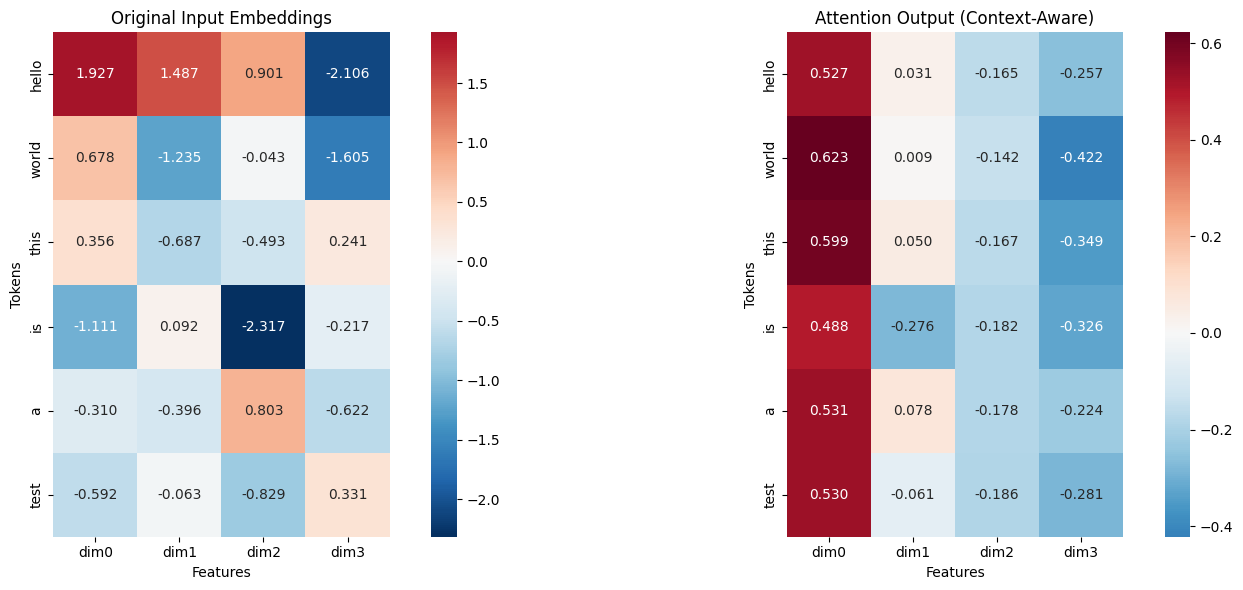

The output embeddings now contain contextual information from the entire sequence!


In [21]:
# Final comparison: Input vs Output
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Original input embeddings
x_2d = x.squeeze(0).detach().numpy()
sns.heatmap(x_2d, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
           xticklabels=feature_labels, yticklabels=sentence, ax=ax1, square=True)
ax1.set_title('Original Input Embeddings')
ax1.set_xlabel('Features')
ax1.set_ylabel('Tokens')

# Attention output
sns.heatmap(output_2d, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
           xticklabels=feature_labels, yticklabels=sentence, ax=ax2, square=True)
ax2.set_title('Attention Output (Context-Aware)')
ax2.set_xlabel('Features')
ax2.set_ylabel('Tokens')

plt.tight_layout()
plt.show()

print("The output embeddings now contain contextual information from the entire sequence!")